## Self Driving Car Nanodegree - Project 3
### Advanced Lane Finding Project
The goals/steps for this project are the following: 
1. Distortion correction using images of chessboards.
2. Perspective transformation to view lane lines from straight above.
3. Processing images to highlight lanelines.
4. Sliding window search to detect lane lines and their curvatures.
5. Drawing the detected lane lines on the original images.

### Step 1 - Distortion correction

In [1]:
# Importing necessary libraries
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

Number of calibration images : 20
Calibration data is acquired


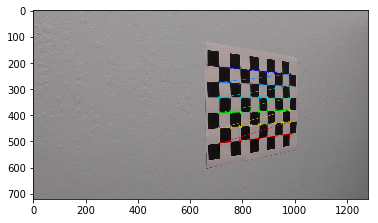

In [2]:
# Number of corners in x and y-axis
nx = 9
ny = 6

# Load calibration images
cal_images = glob.glob('./camera_cal/calibration*.jpg')
print('Number of calibration images :', len(cal_images))

# Empty arrays for object and image points
obj_points = []
img_points = []

# 3 dimemsional object points filled with zeros 
objp = np.zeros((ny * nx, 3), np.float32)

# Prepare sequential object points for each calibration image
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Detect chessboard corners for each calibration image
for filename in cal_images:
    img = cv2.imread(filename)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)   
    ret, corners = cv2.findChessboardCorners(gray_img, (nx, ny), None)
    
    if ret == True:
        obj_points.append(objp)
        img_points.append(corners)
        

# Show the last calibration image with chess board corners drawn
img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
plt.imshow(img)

# Get calibration data from 20 calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray_img.shape[::-1], None, None)

print('Calibration data is acquired')

In [3]:
# method for undistorting images using previously acquired calibration data (mtx and dist)
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

Number of calibration images : 20


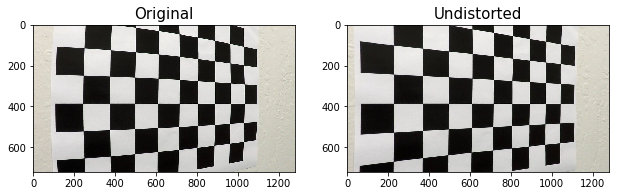

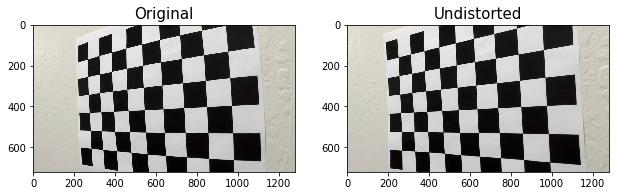

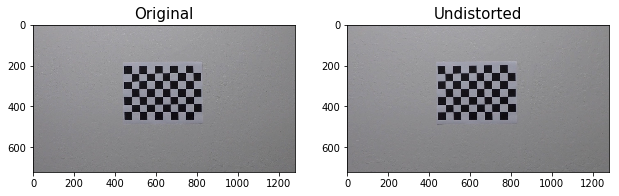

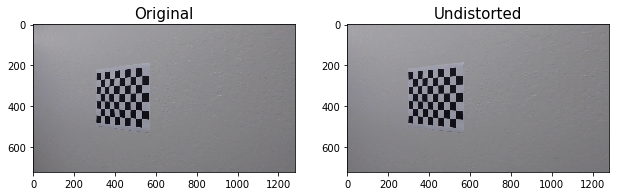

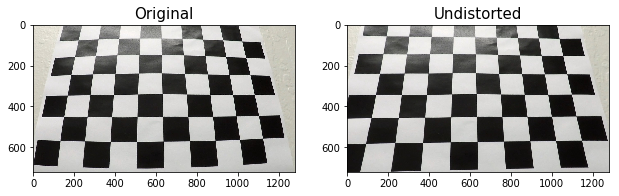

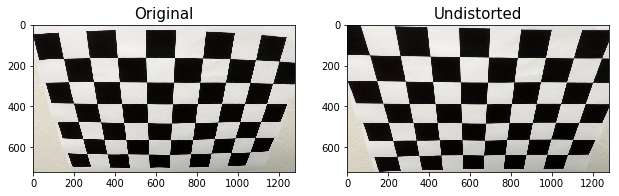

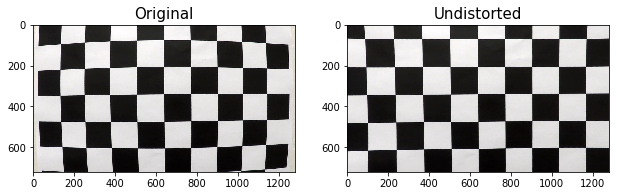

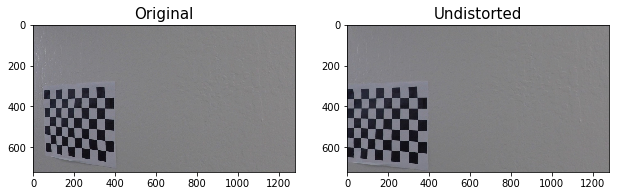

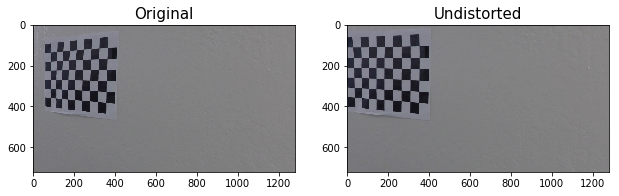

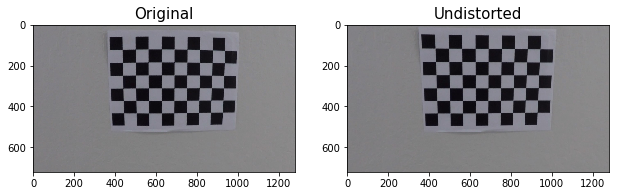

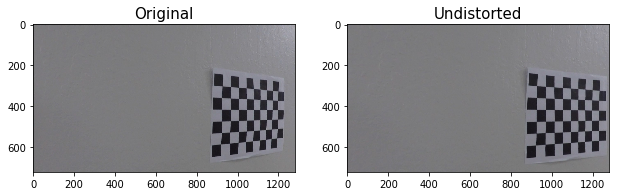

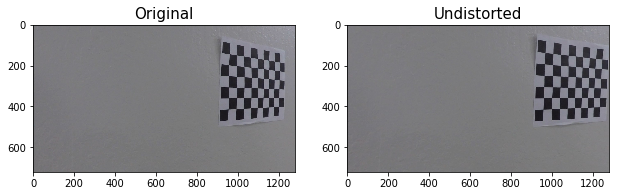

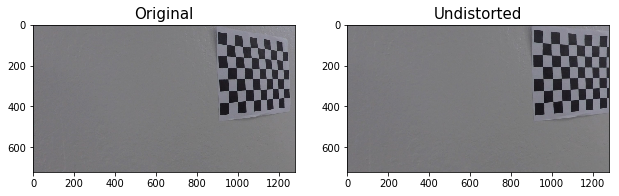

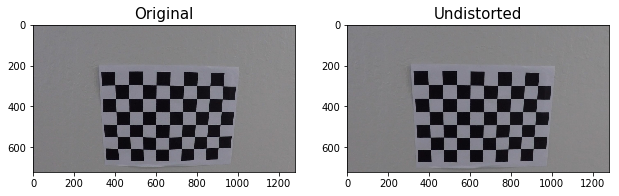

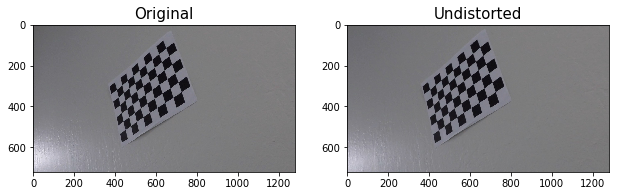

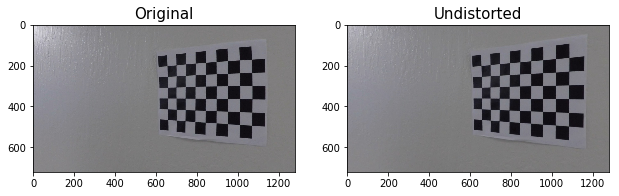

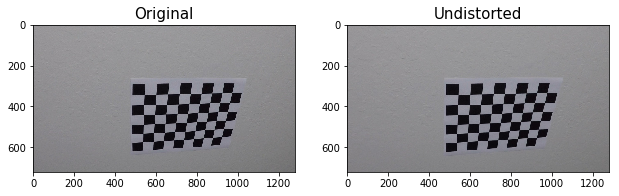

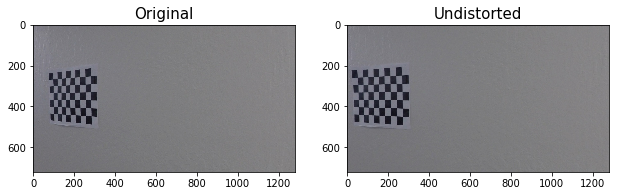

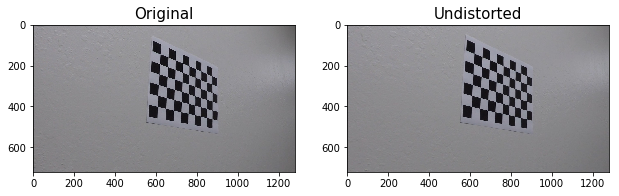

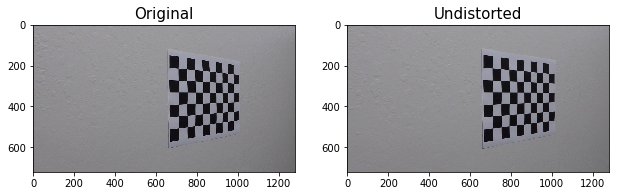

In [4]:
# Test undistort() for all chessboard images
print('Number of calibration images :', len(cal_images))

for img in cal_images:
    orig = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
    undist = undistort(orig)    

    # Plot results
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
    plt.subplot(121)
    plt.imshow(orig)
    plt.title('Original', fontsize = 15)
    plt.subplot(122)
    plt.imshow(undist)
    plt.title('Undistorted', fontsize = 15)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Number of test images : 20


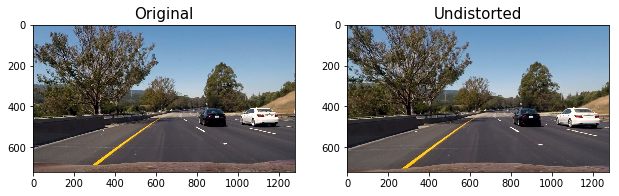

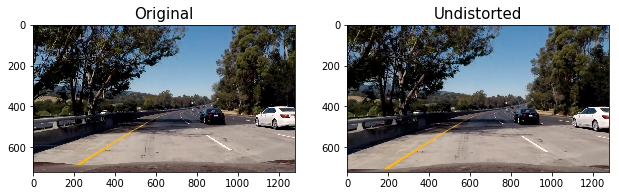

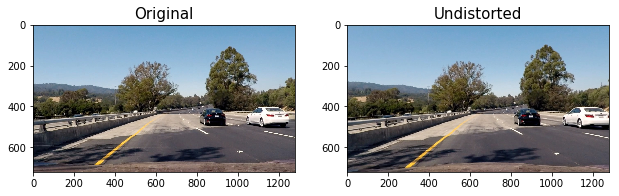

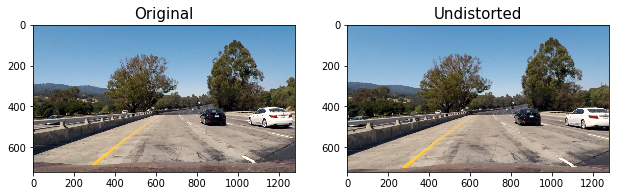

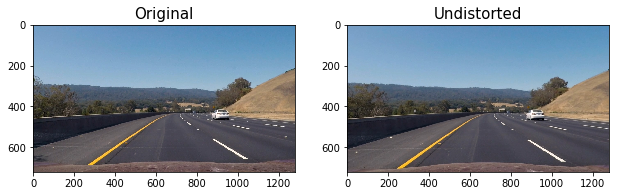

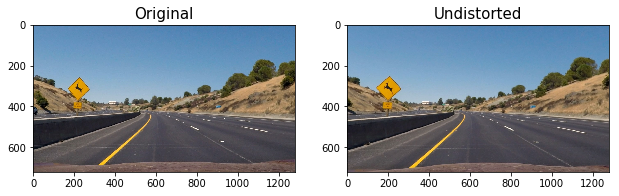

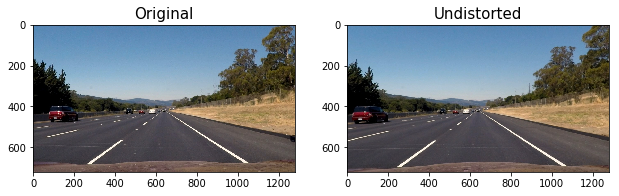

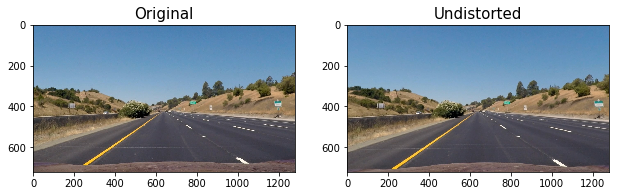

In [5]:
# Test undistort() for all test images
test_images = glob.glob('./test_images/*.jpg')
print('Number of test images :', len(cal_images))


for img in test_images:
    orig = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
    undist = undistort(orig)    

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
    plt.subplot(121)
    plt.imshow(orig)
    plt.title('Original', fontsize = 15)
    plt.subplot(122)
    plt.imshow(undist)
    plt.title('Undistorted', fontsize = 15)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [6]:
def abs_sobel_thresh(img, orient='x', sobel_kernel = 3, thresh=(0, 255)):    
    # Apply x or y gradient with the OpenCV Sobel() function
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
        
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    
    # Using inclusive (>=, <=) thresholds
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

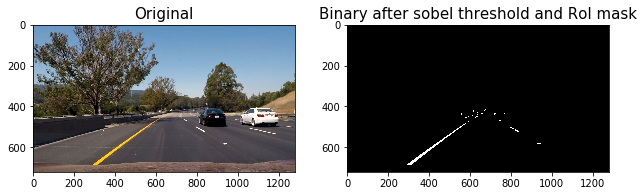

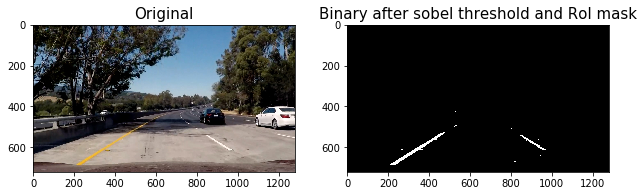

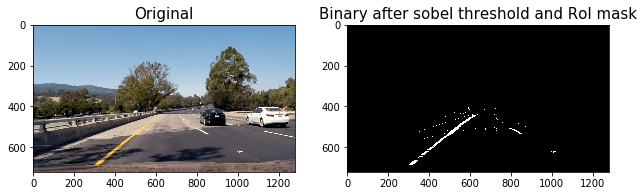

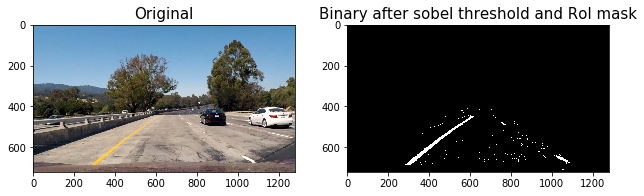

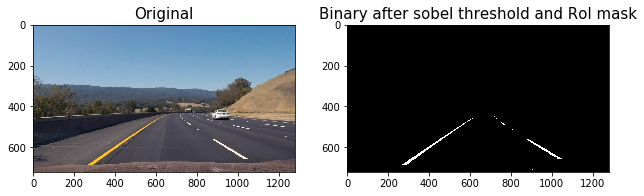

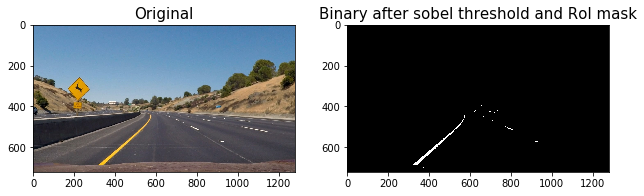

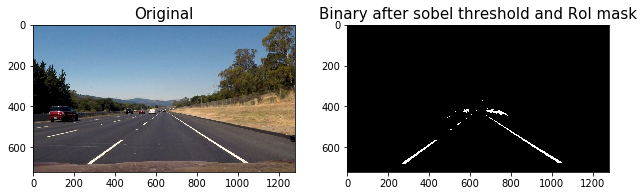

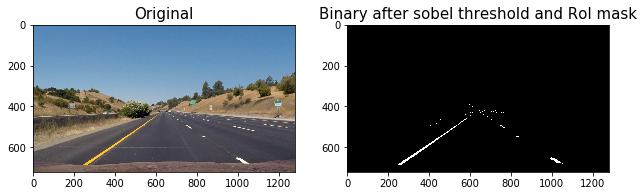

In [7]:
def get_binary(img):
    
    # Undistort the input
    # img = undistort(img)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Get gradient threshold with respect to x-axis
    binary_sobelx = abs_sobel_thresh(gray, orient='x', thresh=(10, 200))
    
    # Get directional threshold with vertial gradients
    binary_dir = dir_threshold(gray, thresh=(np.pi/4, np.pi/2))
    
    # Combine the sobel x gradient and directional threhold
    binary_combined = ((binary_sobelx == 1) & (binary_dir == 1))
    
    # Separate R and G channels and apply color threshold to both channels
    r_channel = img[:,:,0]
    g_channel = img[:,:,1]
    rgb_threshold = 150
    rg = (r_channel > rgb_threshold) & (g_channel > rgb_threshold)
    
    # Convert to HLS color space and get l and s channels with respective threshold limits   
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    s_threshold = (100, 255)
    s = (s_channel > s_threshold[0]) & (s_channel <= s_threshold[1])
    l_threshold = (120, 255)
    l = (l_channel > l_threshold[0]) & (l_channel <= l_threshold[1])
    
    # Combine binary output and HLS channel output    
    combined = np.zeros_like(r_channel)
    combined[(rg & l) & (s | binary_combined)] = 1
    
    # Region of interest mask
    height = img.shape[0]
    width = img.shape[1]
    mask = np.zeros_like(combined)
    roi_vertices = np.array([[0, height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
    cv2.fillPoly(mask, [roi_vertices], 1)
    
    return cv2.bitwise_and(combined, mask)


# Check get_binary() for all test images
for img in test_images:
    test = cv2.imread(img)
    test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
    result = get_binary(test)

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
    plt.subplot(121)
    plt.imshow(test)
    plt.title('Original', fontsize = 15)
    plt.subplot(122)
    plt.imshow(result, cmap='gray')
    plt.title('Binary after sobel threshold and RoI mask', fontsize = 15)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [8]:
def warp(img, src, dst):
        
    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # keep same size as input image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)  
    warped[:,:200] = 0
    return warped, M, Minv

Lane width in pixels after warping :  600.0


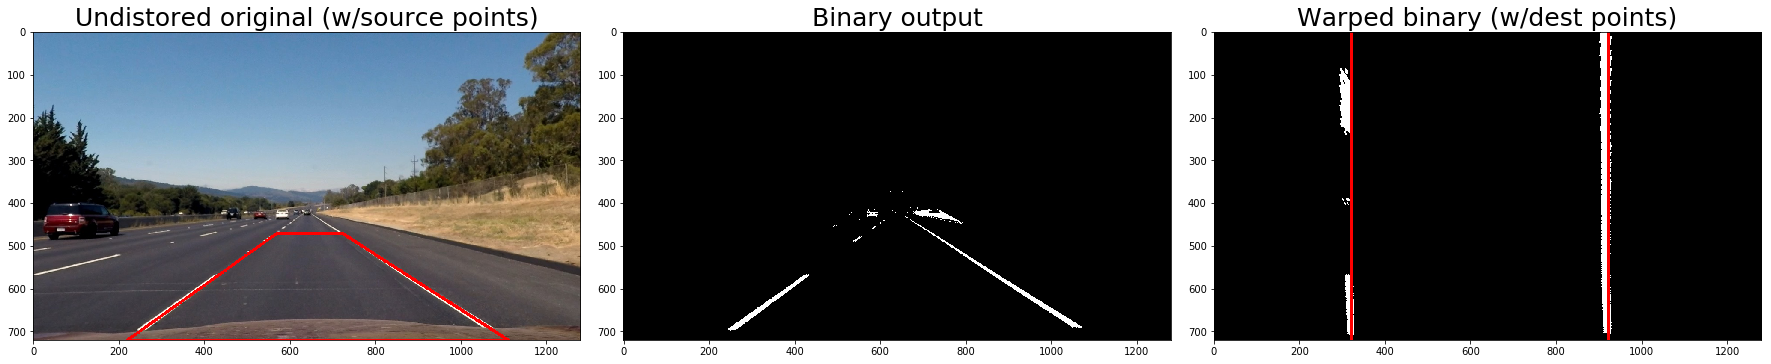

In [9]:
# Test warp()
image = cv2.imread('./test_images/straight_lines2.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

width = image.shape[1]
height = image.shape[0]

# Get undistorted image
undist = undistort(image)

# Get binary image from the undistorted image
binary_output=get_binary(undist)


# Source points to be warped (after many tries...)  
src = np.float32(
    [[width/2 - 70, height/2 + 110],
    [width/2 - 420, height],
    [width/2 + 470, height],
    [width/2 + 82, height/2 + 110]])

# Destination points to be warped   
dst = np.float32(
    [[width/4, 1],        # [320,   1]
    [width/4, height],    # [320, 720]
    [width/4+600, height],# [920, 720]
    [width/4+600, 1]])    # [920,   1]

# warp the binary output
binary_warped, M, Minv = warp(binary_output, src, dst)

width = image.shape[1]
height = image.shape[0]


# draw a trapezoid on the input image
src_img=undist.copy()
cv2.line(src_img,(src[0][0],src[0][1]),(src[1][0],src[1][1]),(255,0,0),5)
cv2.line(src_img,(src[1][0],src[1][1]),(src[2][0],src[2][1]),(255,0,0),5)
cv2.line(src_img,(src[2][0],src[2][1]),(src[3][0],src[3][1]),(255,0,0),5)
cv2.line(src_img,(src[3][0],src[3][1]),(src[0][0],src[0][1]),(255,0,0),5)

temp=binary_warped.copy()
dst_img = np.dstack((temp, temp, temp))*255

# draw two lines on the warped image
cv2.line(dst_img,(dst[0][0],dst[0][1]),(dst[1][0],dst[1][1]),(255,0,0),5)
cv2.line(dst_img,(dst[2][0],dst[2][1]),(dst[3][0],dst[3][1]),(255,0,0),5)
lane_width_in_pixels_warp = dst[2][0] - dst[1][0]
print('Lane width in pixels after warping : ', lane_width_in_pixels_warp)


# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(src_img)
ax1.set_title('Undistored original (w/source points)', fontsize=25)
ax2.imshow(binary_output, cmap='gray')
ax2.set_title('Binary output', fontsize=25)
ax3.imshow(dst_img)
ax3.set_title('Warped binary (w/dest points)', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()


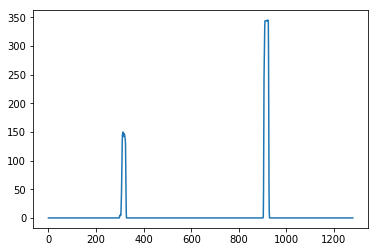

In [10]:
# Testing function from the classroom

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 10

# Set height of windows
window_height = np.int(binary_warped.shape[0]//nwindows)

# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base

# Set the width of the windows +/- margin
margin = 100

# Set minimum number of pixels found to recenter window
minpix = 50

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 0)

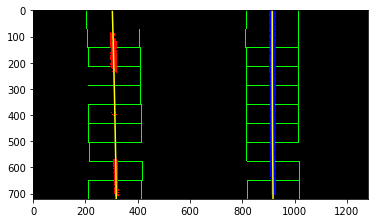

In [11]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Draw output image
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [12]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(720, 0)

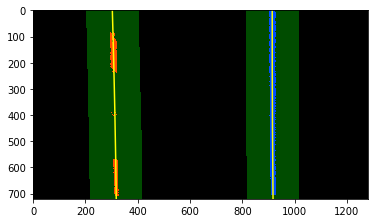

In [13]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [14]:
# Declare global variables to be used
#polyfit_left=None
#polyfit_right=None
#past_good_left_lines = []
#past_good_right_lines = []
#running_mean_difference_between_lines = 0

def get_line_predictions(nonzerox, nonzeroy, left_coordinates, right_coordinates, num_rows):
    """
        Given ncoordinates of non-zeros pixels and coordinates of non-zeros pixels within the sliding windows,
        this function generates a prediction for the lane line.
    """
    left_x = nonzerox[left_coordinates]
    left_y = nonzeroy[left_coordinates]
    
    # If no pixels were found return None
    if(left_y.size == 0 or left_x.size == 0):
        return None, None

    # Fit the polynomial
    polyfit_left = np.polyfit(left_y, left_x, 2)

    right_x = nonzerox[right_coordinates]
    right_y = nonzeroy[right_coordinates]
    
    # If no pixels were found return None
    if(right_y.size == 0 or right_x.size == 0):
        return None, None

    # Fit the polynomial
    polyfit_right = np.polyfit(right_y, right_x, 2)

    # If no pixels were found return None
    y_points = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    
    # Generate the lane lines from the polynomial fit
    left_x_predictions = polyfit_left[0]*y_points**2 + polyfit_left[1]*y_points + polyfit_left[2]
    right_x_predictions = polyfit_right[0]*y_points**2 + polyfit_right[1]*y_points + polyfit_right[2]
    
    return left_x_predictions, right_x_predictions

def brute_search(warped):
    """
        This function searches for lane lines from scratch.
        Thresholding & performing a sliding window search.
    """
    nonzero = warped.nonzero()
    nonzeroy = nonzero[0]
    nonzerox = nonzero[1]
    
    num_rows = warped.shape[0]
    
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
    half_width = np.int(histogram.shape[0]/2)
    leftx = np.argmax(histogram[:half_width])

    rightx = np.argmax(histogram[half_width:]) + half_width

    num_windows = 10
    window_height = np.int(num_rows/num_windows)
    window_half_width = 50

    min_pixels = 100
    
    rightx_current= rightx
    leftx_current= leftx

    left_coordinates = []
    right_coordinates = []

    for window in range(num_windows):
        y_max = num_rows - window*window_height
        y_min = num_rows - (window+1)* window_height

        left_x_min = leftx_current - window_half_width
        left_x_max = leftx_current + window_half_width

        good_left_window_coordinates = ((nonzerox >= left_x_min) & (nonzerox <= left_x_max) & (nonzeroy >= y_min) & (nonzeroy <= y_max)).nonzero()[0]
        left_coordinates.append(good_left_window_coordinates)

        if len(good_left_window_coordinates) > min_pixels:
            leftx_current = np.int(np.mean(nonzerox[good_left_window_coordinates]))

        right_x_min = rightx_current - window_half_width
        right_x_max = rightx_current + window_half_width

        good_right_window_coordinates = ((nonzerox >= right_x_min) & (nonzerox <= right_x_max) & (nonzeroy >= y_min) & (nonzeroy <= y_max)).nonzero()[0]
        right_coordinates.append(good_right_window_coordinates)

        if len(good_right_window_coordinates) > min_pixels:
            rightx_current = np.int(np.mean(nonzerox[good_right_window_coordinates]))

    left_coordinates = np.concatenate(left_coordinates)
    right_coordinates = np.concatenate(right_coordinates)
    
    left_x_predictions, right_x_predictions = get_line_predictions(nonzerox, nonzeroy, left_coordinates, right_coordinates, num_rows)
    return left_x_predictions, right_x_predictions

def get_averaged_line(previous_lines, new_line):
    """
        This function computes an averaged lane line by averaging over previous good frames.
    """
    
    # Number of frames to average over
    num_frames = 12
    
    if new_line is None:
        # No line was detected
        
        if len(previous_lines) == 0:
            # If there are no previous lines, return None
            return previous_lines, None
        else:
            # Else return the last line
            return previous_lines, previous_lines[-1]
    else:
        if len(previous_lines) < num_frames:
            # we need at least num_frames frames to average over
            previous_lines.append(new_line)
            return previous_lines, new_line
        else:
            # average over the last num_frames frames
            previous_lines[0:num_frames-1] = previous_lines[1:]
            previous_lines[num_frames-1] = new_line
            new_line = np.zeros_like(new_line)
            for i in range(num_frames):
                new_line += previous_lines[i]
            new_line /= num_frames
            return previous_lines, new_line
        
def get_mean_distance_between_lines(left_line, right_line, running_average):
    """
        Returns running weighted average of simple difference between left and right lines
    """
    mean_distance = np.mean(right_line - left_line)
    if running_average == 0:
        running_average = mean_distance
    else:
        running_average = 0.9*running_average + 0.1*mean_distance
    return running_average

In [15]:
def pipeline_final(img):
    # global variables to store the polynomial coefficients of the line detected in the last frame
    global polyfit_right
    global polyfit_left
    
    # global variables to store the line coordinates in previous n (=4) frames
    global past_good_right_lines
    global past_good_left_lines
    
    # global variable which contains running average of the mean difference between left and right lanes
    global running_mean_difference_between_lines
    
    img_size = (img.shape[1], img.shape[0])
    
    # get thresholded image
    # thresholded = get_binary(img)
    
    # Get warped binary image by performing a perspective transform
    undist = undistort(img)
    warped = cv2.warpPerspective(get_binary(undist), M, img_size , flags=cv2.INTER_LINEAR)
    
    out_img = np.dstack((warped, warped, warped))*255
    
    nonzero = warped.nonzero()
    nonzeroy = nonzero[0]
    nonzerox = nonzero[1]
    
    num_rows = warped.shape[0]
    y_points = np.linspace(0, num_rows-1, num_rows)
    
    if (polyfit_left is None) or (polyfit_right is None):
        # If the polynomial coefficients of the previous frames are None then perform a brute force search
        brute = True
        left_x_predictions, right_x_predictions = brute_search(warped)
    else:
        # Else search in a margin of 100 pixels on each side of the pervious polynomial fit
        brute = False
        margin = 100
        left_x_predictions = polyfit_left[0]*nonzeroy**2 + polyfit_left[1]*nonzeroy + polyfit_left[2]
        left_coordinates = ((nonzerox >= left_x_predictions - margin) & (nonzerox <= left_x_predictions + margin)).nonzero()[0]

        right_x_predictions = polyfit_right[0]*nonzeroy**2 + polyfit_right[1]*nonzeroy + polyfit_right[2]
        right_coordinates = ((nonzerox >= right_x_predictions - margin) & (nonzerox <= right_x_predictions + margin)).nonzero()[0]
        
        left_x_predictions, right_x_predictions = get_line_predictions(nonzerox, nonzeroy, left_coordinates, right_coordinates, num_rows)
    
    if (left_x_predictions is None or right_x_predictions is None):
        if not brute:
            left_x_predictions, right_x_predictions = brute_search(warped)
            
    bad_lines = False
            
    if (left_x_predictions is None or right_x_predictions is None):
        bad_lines = True
    else:
        mean_difference = np.mean(right_x_predictions - left_x_predictions)
        
        if running_mean_difference_between_lines == 0:
            running_mean_difference_between_lines = mean_difference
        
        if (mean_difference < 0.7*running_mean_difference_between_lines or mean_difference > 1.3*running_mean_difference_between_lines):
            bad_lines = True
            if not brute:
                left_x_predictions, right_x_predictions = brute_search(warped)
                if (left_x_predictions is None or right_x_predictions is None):
                    bad_lines = True
                else:
                    mean_difference = np.mean(right_x_predictions - left_x_predictions)
                    if (mean_difference < 0.7*running_mean_difference_between_lines or mean_difference > 1.3*running_mean_difference_between_lines):
                        bad_lines = True
                    else:
                        bad_lines = False
        else:
            bad_lines = False
            
    if bad_lines:
        polyfit_left = None
        polyfit_right = None
        if len(past_good_left_lines) == 0 and len(past_good_right_lines) == 0:
            return img
        else:
            left_x_predictions = past_good_left_lines[-1]
            right_x_predictions = past_good_right_lines[-1]
    else:
        past_good_left_lines, left_x_predictions = get_averaged_line(past_good_left_lines, left_x_predictions)
        past_good_right_lines, right_x_predictions = get_averaged_line(past_good_right_lines, right_x_predictions)
        mean_difference = np.mean(right_x_predictions - left_x_predictions)
        running_mean_difference_between_lines = 0.9*running_mean_difference_between_lines + 0.1*mean_difference
    
    left_line_window = np.array(np.transpose(np.vstack([left_x_predictions, y_points])))
    right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_x_predictions, y_points]))))
    
    # compute the radius of curvature
    left_curve_rad = radius_of_curvature(left_x_predictions)
    right_curve_rad = radius_of_curvature(right_x_predictions)
    average_curve_rad = (left_curve_rad + right_curve_rad)/2
    curvature_string = "Radius of curvature: %.0f m" % average_curve_rad
    
    # compute the offset from the center
    lane_center = (right_x_predictions[num_rows-1] + left_x_predictions[num_rows-1])/2
    xm_per_pix = 3.7/600 # meters per pixel in x dimension
    center_offset_pixels = img_size[0]/2 - lane_center
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    offset_string = "Center offset ('-' to the left') : %.2f m" % center_offset_mtrs
    
    poly_points = np.vstack([left_line_window, right_line_window])
    
    cv2.fillPoly(out_img, np.int_([poly_points]), [0,255, 0])
    
    unwarped = cv2.warpPerspective(out_img, Minv, img_size , flags=cv2.INTER_LINEAR)

    result = cv2.addWeighted(img, 1, unwarped, 0.3, 0)
    
    cv2.putText(result,curvature_string , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(result, offset_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    
    return result

In [16]:
def radius_of_curvature(x_values):
    # 15 meters per pixel in y dimension, considering that each dotted lane is about 3 meters
    # and there are approximately 5 dotted lanes within warped binary image (720 pixels high)
    ym_per_pix = 15/720 
    # 3.7 meters per pixel in x dimension, the lane width is always 3.7 meters by regulation.
    # The pixel width after warp is 600 pixels, because ( dst[1][0] - dst[2][0] ) gives 920 - 320 = 600
    xm_per_pix = 3.7/600 
    
    # If no pixels were found return None
    y_points = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    y_eval = np.max(y_points)

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y_points*ym_per_pix, x_values*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

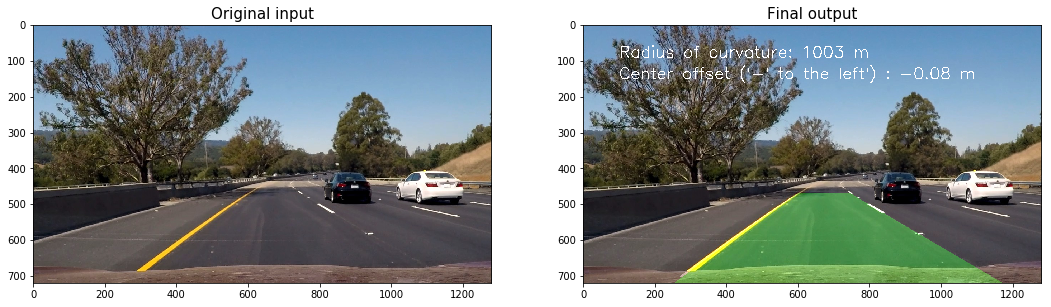

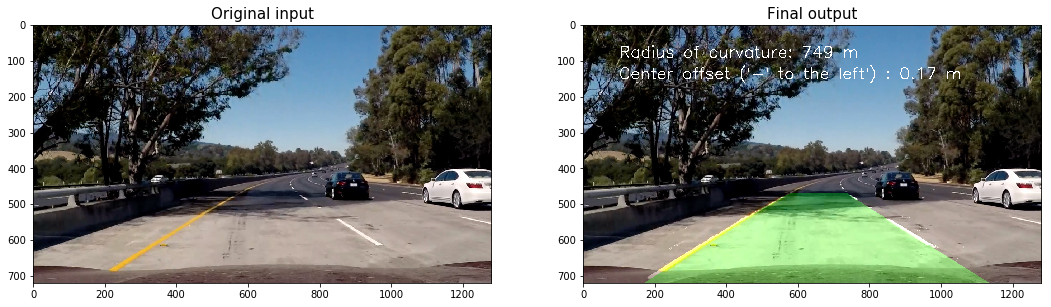

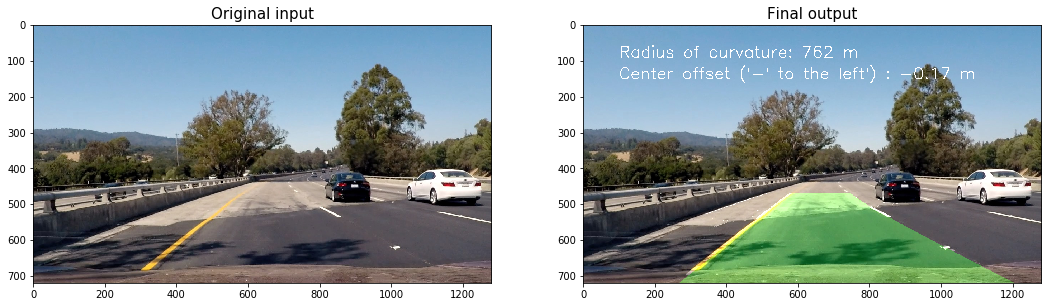

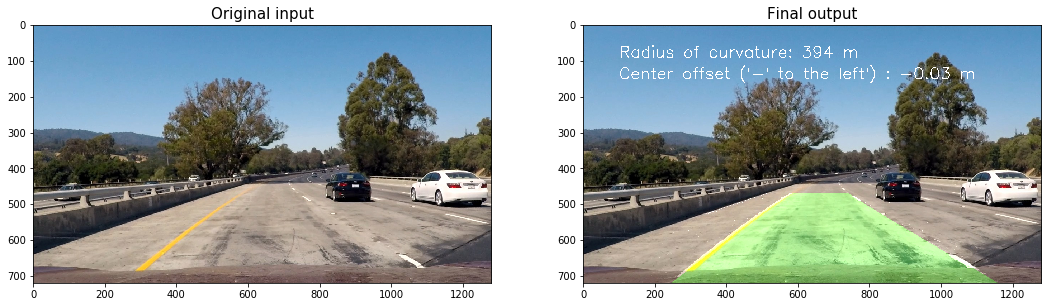

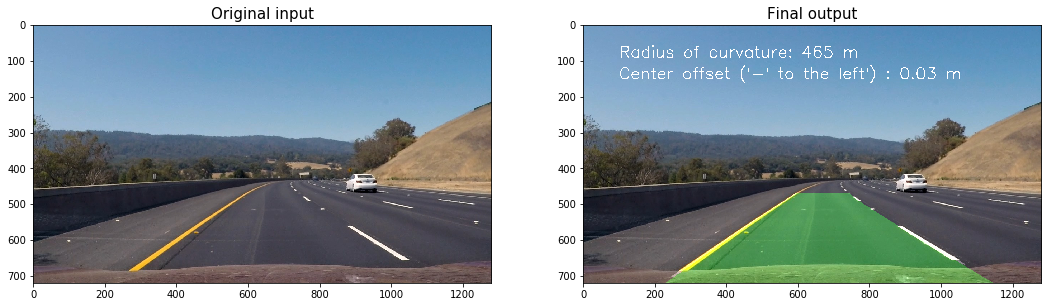

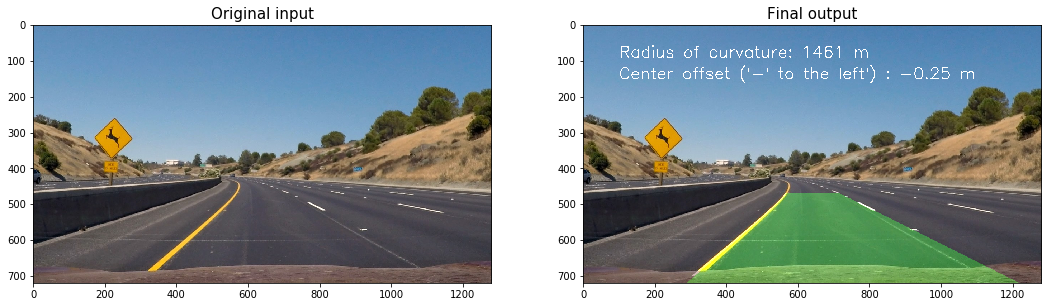

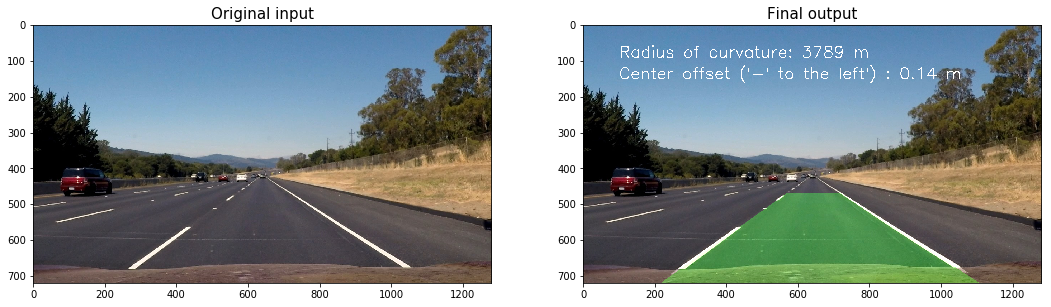

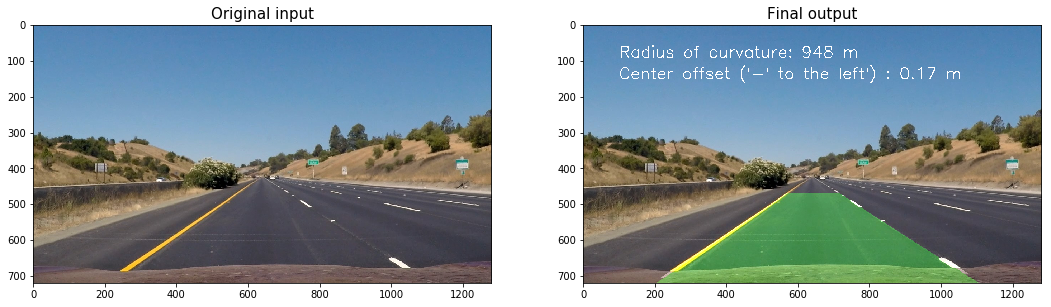

In [17]:
# img = mpimg.imread('test_images/test6.jpg')

# Reinitialize all global variables.
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0

# Apply pipeline
# final_output = pipeline_final(img)

# Check for all test images
for img in test_images:
    test = cv2.imread(img)
    test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
    final_output = pipeline_final(test)

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))
    plt.subplot(121)
    plt.imshow(test)
    plt.title('Original input', fontsize = 15)
    plt.subplot(122)
    plt.imshow(final_output, cmap='gray')
    plt.title('Final output', fontsize = 15)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [18]:
from moviepy.editor import VideoFileClip
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0
challenge_output = 'challenge_result.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
challenge_clip = clip1.fl_image(pipeline_final) 
challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video challenge_result.mp4
[MoviePy] Writing video challenge_result.mp4


100%|██████████| 485/485 [00:59<00:00,  8.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_result.mp4 



In [19]:
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0
challenge_output = 'harder_challenge_result.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
challenge_clip = clip1.fl_image(pipeline_final) 
challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video harder_challenge_result.mp4
[MoviePy] Writing video harder_challenge_result.mp4


100%|█████████▉| 1199/1200 [03:01<00:00,  6.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_result.mp4 

